# Hourly traffice volume prediction on Interstate 94

#### __Multivaraite time series perdiction with getML__

In this tutoiral, we demonstrate a time series application of getML. We predict the hourly traffic volume on I-94 westbound from Minneapolis-St Paul. 
We benchmark our results against [Facebook's Prophet](https://facebook.github.io/prophet/). It turned out that getML's relational learning algorithms outperform Prophet's classical time series approach by ~13 percent.

Summary:

- Prediction type: __Regression model__
- Domain: __Tranpsortion__
- Prediction target: __Hourly traffic volume__ 
- Source data: __Multivariate time series, 5 components__
- Population size: __24096__

_Author: Sören Nikolaus_

#### __Background__

The dataset features some particularly interesting characteristics common for time series, which classical models may struggle to appropriately deal with. Such characteristics are:

- High frequency (hourly)
- Dependence on irregular events (holidays)
- Strong and overlapping cycles (daily, weekly)
- Anomalies
- Multiple seasonalities


The analysis is built on top of a dataset provided by the [MN Department of Transportation](https://www.dot.state.mn.us), with some data preparation done by [John Hogue](https://github.com/dreyco676/Anomaly_Detection_A_to_Z/). 

Let's get started with the analysis and set-up your session

In [1]:
import os
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline  

import getml

print(f"getML API version: {getml.__version__}\n")

getml.engine.set_project('interstate94')

getML API version: 0.12.0-datasets.3

Loading existing project 'interstate94'


## 1. Loading data


### 1.1 Download from source

Downloading the raw data and convert it into a prediction ready format takes time. To get to the getML model building as fast as possible, we prepared the data for you and excluded the code from this notebook. It is made avaliable in the example notebook featuring the full analysis.

In [2]:
data = getml.datasets.load_interstate94(roles=True, units=True)
traffic_test, traffic_train, _ = data.values()
traffic = getml.data.concat("traffic", [traffic_test, traffic_train])

### 1.2 Prepare data for getML

The `getml.datasets.load_interstate94` method took care of the entire data lifting:
* Downloads csv's from our servers into python
* Converts csv's to getML [DataFrames]()
* Sets [roles]() & [units]() to columns inside getML DataFrames

__Data visualization__

The weekly mean of the original traffic time series is plotted below. We only include data after 2016 and introduced a fixed train/test split at 80% of the avaliable data. 

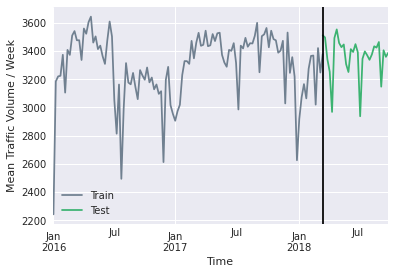

In [3]:
col_data = 'slategray'
col_getml = 'darkviolet'
col_getml_alt = 'coral'
col_prophet = 'cornflowerblue'

t_split = pd.Timestamp(traffic_train['ds'].max().get(), unit='s')

traffic_train.to_pandas().set_index('ds').resample('1w').mean()['Traffic_Volume'].plot(label='Train', color=col_data)
traffic_test.to_pandas().set_index('ds').resample('1w').mean()['Traffic_Volume'].plot(label='Test', color='mediumseagreen')
plt.legend()
plt.ylabel('Mean Traffic Volume / Week')
plt.xlabel('Time')
plt.axvline(t_split, color='black')
plt.show()

__Traffic__: population table

To allow the algorithm to capture seasonal information, we include time components (such as the day of the week) as categorical variables.

In [4]:
traffic

Name,ds,join_key,Traffic_Volume,holiday,hour,weekday,day,month,year,lower_window,upper_window,ds_day
Role,time_stamp,join_key,target,categorical,categorical,categorical,categorical,categorical,categorical,unused_float,unused_float,unused_string
Unit,"time stamp, comparison only",,,,,,,,,,,
0,2018-03-14T04:00:00.000000Z,1,903,No holiday,4,2,14,3,2018,nan,nan,2018-03-14 00:00:00
1,2018-03-14T05:00:00.000000Z,1,2785,No holiday,5,2,14,3,2018,nan,nan,2018-03-14 00:00:00
2,2018-03-14T06:00:00.000000Z,1,5526,No holiday,6,2,14,3,2018,nan,nan,2018-03-14 00:00:00
3,2018-03-14T07:00:00.000000Z,1,6542,No holiday,7,2,14,3,2018,nan,nan,2018-03-14 00:00:00
4,2018-03-14T08:00:00.000000Z,1,5854,No holiday,8,2,14,3,2018,nan,nan,2018-03-14 00:00:00
,...,...,...,...,...,...,...,...,...,...,...,...
24091,2018-03-13T23:00:00.000000Z,1,1287,No holiday,23,1,13,3,2018,nan,nan,2018-03-13 00:00:00
24092,2018-03-14T00:00:00.000000Z,1,665,No holiday,0,2,14,3,2018,nan,nan,2018-03-14 00:00:00


### 1.3 Define relational model

To start with relational learning, we need to specify the data model. We manually replicate the appropriate time series structure by setting time series related join conditions (`horizon`, `memory` and `allow_lagged_targets`). This is done abstractly using [Placeholders](https://docs.getml.com/latest/user_guide/data_model/data_model.html#placeholders)

The data model consists of two tables:
* __Population table__ `traffic_{test/train}`: holds target and the contemporarily available time-based components
* __Peripheral table__ `traffic`: same table as as the population table
* Join between both placeholders specifies (`horizon`) to prevent leaks and (`memory`) that keeps the the computations feasible

In [5]:
population = getml.data.Placeholder('population')

peripheral = getml.data.Placeholder('peripheral')

# 1. The horizon is 1 hour (we predict the next hour). 
# 2. The memory is 7 days, so we allow the algorithm to 
#    use information from up to 7 days. 
# 3. We allow lagged targets, thus the algorithm is able to 
#    identify autoregressive processes.

population.join(
    peripheral,
    join_key='join_key',
    time_stamp='ds',
    horizon=getml.data.time.hours(1),
    memory=getml.data.time.days(7),
    allow_lagged_targets=True
)

population

placeholder,other placeholder,allow lagged targets,horizon,join keys used,memory,other join keys used,other time stamps used,time stamps used,upper time stamps used
population,peripheral,True,3600.0,join_key,604800.0,join_key,ds,ds,


## 2.Predictive modelling

We loaded the data, defined the roles, units and the abstract data model. Next, we create a getML pipeline for relational learning.

### 2.1 getML Pipeline

<!-- #### 2.1.1  -->
__Set-up of feature learners, selectors & predictor__

In [6]:
multirel = getml.feature_learning.MultirelModel(
    num_features=10,
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    seed=4367,
    num_threads=1
)

relboost = getml.feature_learning.RelboostModel(
    num_features=10,
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    seed=4367,
    num_threads=1
)

predictor = getml.predictors.XGBoostRegressor(reg_lambda=500)

__Build the pipeline__

In [7]:
pipe = getml.pipeline.Pipeline(
    tags=['memory: 7d', 'horizon: 1h', 'multirel', 'relboost'],
    population=population,
    peripheral=[peripheral],
    feature_learners=[multirel, relboost],
    predictors=[predictor]
)

### 2.2 Model training

In [8]:
pipe.fit(traffic_train, [traffic])

Checking data model...
OK.

MultirelModel: Training features...
[========================================] 100%

RelboostModel: Training features...
[========================================] 100%

MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:6m:15.263541



Pipeline(feature_learners=['MultirelModel', 'RelboostModel'], 
         feature_selectors=[], include_categorical=False, 
         peripheral=['peripheral'], population='population', 
         predictors=['XGBoostRegressor'], 
         tags=['memory: 7d', 'horizon: 1h', 'multirel', 'relboost'], 
         share_selected_features=0.5)

url: /user/getml-getml-demo-3zekl4hz/proxy/1709/getpipeline/71y5VK/0/

### 2.3 Model evaluation

In [9]:
in_sample = pipe.score(
        population_table=traffic_train,
        peripheral_tables=[traffic]
)

out_of_sample = pipe.score(
        population_table=traffic_test,
        peripheral_tables=[traffic]
)

print("""
In sample mae: {:.2f}
In sample rmse: {:.2f}
In sample rsquared: {:.2f}\n
Out of sample mae: {:.2f}
Out of sample rmse: {:.2f}
Out of sample rsquared: {:.2f}
""".format(
    in_sample['mae'][0], 
    in_sample['rmse'][0],
    in_sample['rsquared'][0],
    out_of_sample['mae'][0], 
    out_of_sample['rmse'][0],
    out_of_sample['rsquared'][0])
)


MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%


MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%


In sample mae: 220.82
In sample rmse: 340.74
In sample rsquared: 0.97

Out of sample mae: 201.48
Out of sample rmse: 320.24
Out of sample rsquared: 0.97



### 2.4 Studying features

__Feature correlations__

Correlations of the calculated features with the target

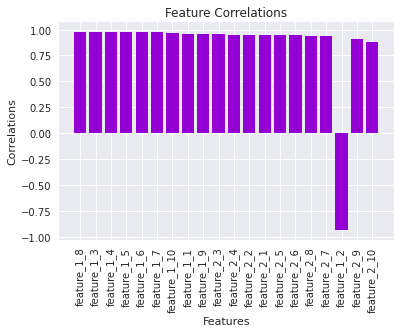

In [10]:
names, correlations = pipe.features.correlations()
plt.bar(names, correlations, color=col_getml)
plt.title('Feature Correlations')
plt.xlabel('Features')
plt.ylabel('Correlations')
plt.xticks(rotation='vertical')
plt.show()

__Feature importances__

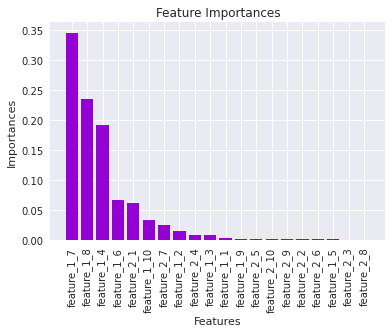

In [11]:
names, importances = pipe.features.importances()

plt.bar(names, importances, color=col_getml)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

most_important = names[0]

__Viszualizing the learned features__

SQL transpilation of most important Multirel feature. Here, Multirel aggregated past values of the target (from up to one week ago) conditonal on time-related components to resemble the daily, weekly and montly cycles in the series. We expect this approach to work reasonably well because the series exhibits strong and stable time-related patterns. 

In [12]:
pipe.features.to_sql()[most_important]

```sql
CREATE TABLE "FEATURE_1_7" AS
SELECT SUM( t2."Traffic_Volume" ) AS "feature_1_7",
       t1.rowid AS "rownum"
FROM "population" t1
LEFT JOIN "peripheral" t2
ON t1."join_key" = t2."join_key"
WHERE (
   ( ( datetime( t1."ds" ) > datetime( t2."ds", '+6.962922 days' ) ) AND ( t2."hour" NOT IN ( '23', '0', '1', '2' ) ) AND ( t1."holiday" IN ( 'Independence Day', 'Labor Day' ) ) AND ( t2."hour" NOT IN ( '5', '6' ) ) )
OR ( ( datetime( t1."ds" ) > datetime( t2."ds", '+6.962922 days' ) ) AND ( t2."hour" IN ( '23', '0', '1', '2' ) ) AND ( t2."day" NOT IN ( '4' ) ) AND ( t1."holiday" NOT IN ( 'Martin Luther King Jr Day', 'Columbus Day' ) ) )
OR ( ( datetime( t1."ds" ) <= datetime( t2."ds", '+6.962922 days' ) ) AND ( datetime( t1."ds" ) > datetime( t2."ds", '+1.295900 hours' ) ) AND ( datetime( t1."ds" ) > datetime( t2."ds", '+6.946057 days' ) ) AND ( t1."holiday" NOT IN ( 'Independence Day', 'Labor Day' ) ) )
OR ( ( datetime( t1."ds" ) <= datetime( t2."ds", '+6.962922 days' ) ) AND ( datetime( t1."ds" ) <= datetime( t2."ds", '+1.295900 hours' ) ) AND ( t2."hour" NOT IN ( '22', '23', '0', '1', '2', '3' ) ) AND ( t2."holiday" NOT IN ( 'Memorial Day', 'Labor Day', 'Thanksgiving Day', 'Christmas Day' ) ) )
) AND datetime( t2."ds", '+1.000000 hours' ) <= datetime( t1."ds" )
AND ( datetime( t2."ds", '+7.041667 days' ) > datetime( t1."ds" ) OR datetime( t2."ds", '+7.041667 days' ) IS NULL )
GROUP BY t1.rowid;
```

__Plot feature & traffic volume vs. time__

Plot the most important feature against the observed values of the target for the last 7 days of the training set. You can see that this feature closely follows the original series. Multirel was able to identify certain patterns in the series, including:
- Day and night separation 
- The daily commuting peeks (on weekdays)
- The decline on weekends



In [13]:
features = pipe.transform(traffic_train, [traffic], df_name=f'{pipe.name}_features')


MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%



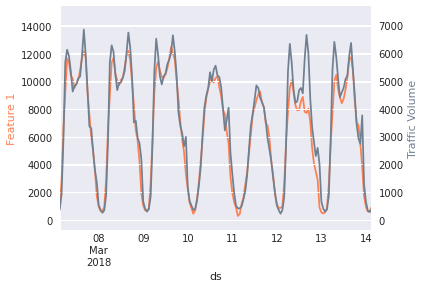

In [14]:
fig, ax1 = plt.subplots()

features.to_pandas().set_index('ds')[most_important].plot(ax=ax1, color=col_getml_alt)
ax1.set_ylabel('Feature 1', color=col_getml_alt)

ax2 = ax1.twinx()  
ax2.set_ylabel('Traffic Volume', color=col_data)
traffic_train.to_pandas().set_index('ds')['Traffic_Volume'].plot(ax=ax2, color=col_data)

fig.tight_layout()
plt.xlim(t_split - pd.Timedelta('7d'), t_split)
plt.show()

## 3. Benchmark

__Benchmarks against Prophet__

By design, Prophet isn't capable of delivering the 1-step ahead predictions we did with getML. In order to retrieve a benchmark in the 1-step case nonetheless, we mimic 1-step ahead predictions through cross validating the model on a rolling origin. This clearly gives Prophet an advantage as all information up to the origin is incorporated when *fitting* the model and a new fit is calculated for every 1-step ahead forecast. If you are interested in the full analysis please referr to the extended version of this [notebook](getml_examples/interstate94/interstate94.ipynb).


__Results__

We have benchmarked getML against Facebook’s Prophet library on a univariate time series with strong seasonal components.
Prophet is made for exactly these sort of data sets, so you would expect this to be a home run for Prophet. The opposite is true - getML’s relational learning algorithms outperform Prophet's 1-step ahead predictions by ~14 percentage points:

* R-squared Prophet: 83.3%
* R-squared getML: 97.2%